# Huixiang Liu's Assignment

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
%pwd

'/home/huixiang/6015/week2'

In [3]:
my_path = '/home/huixiang/6015/week2'

In [4]:
my_df = pd.read_csv('/home/huixiang/6015/week2/Titanic_full.csv')

In [5]:
my_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
def my_splitter(my_df, nums_rows):
    return my_df[:nums_rows].copy(), my_df[nums_rows:]

mydf_train, mydf_test = my_splitter(my_df, 1100)

In [7]:
#check if the dataframe is correctly sliced
print(mydf_train.shape, mydf_test.shape)

(1100, 12) (209, 12)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


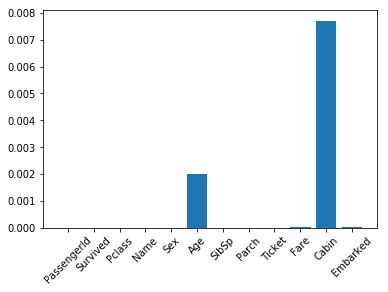

In [8]:
#using plot instead of sns
null_vals = mydf_train.isnull().sum() / (len(mydf_train) * 100)
print(null_vals.index)
plt.bar(null_vals.index, null_vals)
plt.xticks(rotation = 45)
plt.show()

In [9]:
#Drop Cabin column
mydf_train = mydf_train.drop("Cabin", axis = 1) # axis = 1 stands for column

In [10]:
print(mydf_train.info()) #check data-type and null-value data numbers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null object
Sex            1100 non-null object
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null object
Fare           1099 non-null float64
Embarked       1098 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 94.6+ KB
None


In [11]:
def str_to_cat(my_df):
    for key, value in my_df.items():
        if is_string_dtype(value):
            my_df[key] = value.astype('category') # check what does .cat.asordered() do
    return my_df

In [12]:
mydf_train = str_to_cat(mydf_train)

In [13]:
mydf_train.info() #check if all the ob

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null category
Sex            1100 non-null category
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null category
Fare           1099 non-null float64
Embarked       1098 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [14]:
# Now comes the hardest part: define the imputer method
def mydf_to_nums(df, label, value):#convert Nan. to 0 by add 1
    if not is_numeric_dtype(value): # if this is not a numeric type, we add it by one
        df[label] = value.cat.codes + 1
        
def my_imputer(df, label, value, imputed_table):
    if is_numeric_dtype(value): #only impute numeric columns
        if pd.isnull(value).sum() or (label in imputed_table): # if there's null value in this column or this column
                                                               # has been imputed
            df[label + '_na'] = pd.isnull(value) #add another column to mark if this is a imputed value or not
            filler = imputed_table[label] if label in imputed_table else value.median() #check table first, otherwise
                                                                                        # we calculate median
            df[label] = value.fillna(filler)
            imputed_table[label] = filler # add the imputed number in the table
    return imputed_table

def my_preprocessor(df, imputed_table):
    
    if imputed_table is None:
        imputed_table = dict()
    for label, value in df.items():
        imputed_table = my_imputer(df, label, value, imputed_table)
    for label, value in df.items():
        mydf_to_nums(df, label, value)
    df = pd.get_dummies(df, dummy_na = True) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies
    result = [df, imputed_table]
    
    return result
    
    

__[More information about pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)__

In [15]:


mydf_train, my_fill_table = my_preprocessor(mydf_train, None)
mydf_train.info() #check if we have filled all Nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 13 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null int16
Sex            1100 non-null int8
Age            1100 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null int16
Fare           1100 non-null float64
Embarked       1100 non-null int8
Age_na         1100 non-null bool
Fare_na        1100 non-null bool
dtypes: bool(2), float64(2), int16(2), int64(5), int8(2)
memory usage: 68.8 KB


In [16]:
my_fill_table #check what data we have filled

{'Age': 28.0, 'Fare': 14.4583}

In [17]:
y = mydf_train["Survived"]
X = mydf_train.drop('Survived', axis = 1)

In [18]:
# Before we move to knn, we need to standarized numerical data in the DataFrame
# From mydf_train.info(), we can see that 'Age' and 'Fare' need to be standarized
print(mydf_train['Age'].mean(), mydf_train['Age'].std(), mydf_train['Fare'].mean(), mydf_train['Fare'].std())

29.450454545454544 12.96554835698059 32.971412272727264 51.24535879626586


In [19]:
# At first, we split Age and fare from the other column
X_to_be_standrized = X[['Age', 'Fare']] # Need two [], need to ask professor later
X_leftover = X.drop(X_to_be_standrized, axis = 1)

In [20]:
X_scaled = pd.DataFrame(preprocessing.scale(X_to_be_standrized))
X_scaled.columns = ['Age', 'Fare'] # Add column to the new list

In [21]:
df_list = [X_leftover, X_scaled]
X_full = pd.concat(df_list, axis = 1)

In [22]:
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, random_state = 0)
print(X_train.shape,X_valid.shape,y_train.shape,y_valid.shape)

(825, 12) (275, 12) (825,) (275,)


In [24]:
X_full.head(2)

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [25]:
my_knn_model = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
my_knn_model.fit(X_train, y_train)
y_pred = my_knn_model.predict(X_valid)

In [26]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_valid))) # The evaluation method from the book

Test set score: 0.57


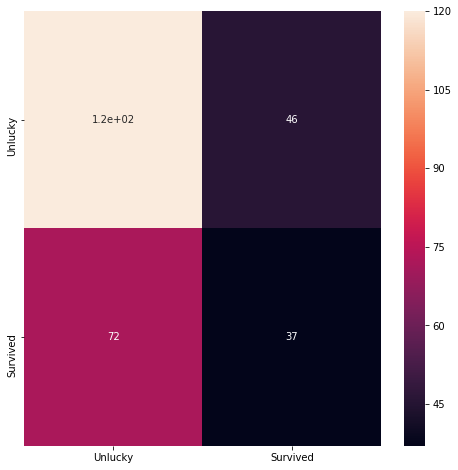

In [27]:
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(y_valid, y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [28]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_valid))) # The evaluation method from the book

Test set score: 0.57


In [29]:
print(accuracy_score(y_valid, y_pred),
     matthews_corrcoef(y_valid, y_pred), f1_score(y_valid, y_pred))

0.5709090909090909 0.06642814823362306 0.3854166666666667


# Tuning Hyperparameter
## 1.Tuning value of k

In [30]:
num_neighs = list()
accuracy_list = list()

for neighbor in range(1, 20):
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor, weights = 'uniform')
    my_knn_model.fit(X_train, y_train)
    y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

In [31]:
Accuracy_df = pd.DataFrame({"Num of neighbors" : num_neighs, "Valid accuracy Score": accuracy_list})
Accuracy_df

,Num of neighbors,Valid accuracy Score
0,1,0.560000
1,2,0.574545
2,3,0.570909
3,4,0.560000
4,5,0.570909
5,6,0.585455
6,7,0.570909
7,8,0.596364
8,9,0.563636
9,10,0.574545


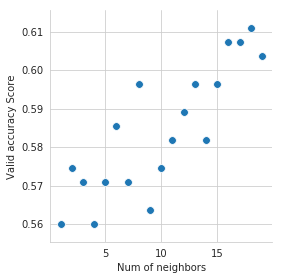

In [32]:
sns.set_style("whitegrid")
sns.pairplot(Accuracy_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

## 2.Tuning weight

In [33]:
weights_list = ["uniform", "distance"]
weights_result = list()

In [34]:
for weight in weights_list:
    knn = KNeighborsClassifier(n_neighbors = 17, weights = weight)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    
    weights_result.append(accuracy)

In [35]:
Accuracy_df = pd.DataFrame({"weights type" :weights_list, "Accuracy" : weights_result})
Accuracy_df

,weights type,Accuracy
0,uniform,0.607273
1,distance,0.600000


## 3. Tuning metric

In [36]:
metric_list = ["euclidean", "manhattan", "chebyshev", "minkowski"]
metric_result = list()

In [37]:
for metric in metric_list:
    knn = KNeighborsClassifier(n_neighbors = 17, metric = metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    
    metric_result.append(accuracy)

In [38]:
Accuracy_df = pd.DataFrame({"Metric type" :metric_list, "Accuracy" : metric_result})
Accuracy_df

,Metric type,Accuracy
0,euclidean,0.607273
1,manhattan,0.592727
2,chebyshev,0.614545
3,minkowski,0.607273


***
# Question 2: My opinion about kNN's disadvantages
- According to project Titanic, kNN does not provide a good prediction
- We cannot predict which parameter need to be tuned except by brute-force